# Reverse Image Search

## Scenario introduction

**Reverse image search** helps you search for similar or related images given an input image. Reverse image search is a [content-based image retrieval](https://en.wikipedia.org/wiki/Content-based_image_retrieval) (CBIR) query technique that involves providing the CBIR system with a query image that it will then base its search upon. Unlike the traditional image search (which often relies on performing text queries across user-generated labels), reverse image search is based on the content of the image itself.

A few applications of reverse image search include finding the original source of an image, searching for similar content, and product recommendation.

## Tutorial overview

Building a reverse image search system typically involves the following steps:
1. model and pipeline selection
2. computing embedding vectors for the existing image dataset
3. insert all generated embedding vectors into a vector database
4. process search queries

A block diagram for a basic reverse image search system is shown in the images below. The first image shows how an existing image dataset is transformed into embedding vectors and inserted into a vector database, while the second image shows how the system processes query images.

**FIRST IMAGE HERE(INSERT)**

![img](https://github.com/towhee-io/towhee/raw/main/docs/tutorials/reverse_image_search_step1.png?raw=true)

**SECOND IMAGE HERE(SEARCH)**

![img](https://github.com/towhee-io/towhee/raw/main/docs/tutorials/reverse_image_search_step2.png?raw=true)

In the upcoming sections, we will first walk you through some of the prep work required for this tutorial. After that, we will elaborate on each of the four steps mentioned above.

## Preparation

In this step, we will download the image dataset, install [Towhee](https://towhee.io), and setup [Milvus](https://milvus.io), an open source vector database.

### Download the image dataset

In this tutorial, we will use a subset of the ImageNet dataset (100 classes, 10 images for each class). You can download the dataset via:

- Google Drive: https://drive.google.com/file/d/1bg1RtUjeZlOfV2BiA2nf7sn5Jec9b-9I/view?usp=sharing
- Dropbox: https://www.dropbox.com/s/ucv15cxblok84x0/image_dataset.zip?dl=0
- Aliyun Drive: https://www.aliyundrive.com/s/dLdeDWEhcnr

In this tutorial, we will use `gdown` to download and unzip the data from Google Drive.

In [ ]:
! pip3 install gdown
! gdown "https://drive.google.com/uc?id=1bg1RtUjeZlOfV2BiA2nf7sn5Jec9b-9I"
! unzip -q image_dataset.zip

The downloaded data contains two directories - `dataset` for the image dataset and `query` for the query images.

### Install Towhee

We'll use `pip` in this tutorial. We also support installing Towhee via `conda` as well as from source; check out [this page](https://docs.towhee.io/get-started/install) for more information.

In [ ]:
! pip3 install towhee

### Setup Milvus

Milvus is an open-source vector database built to power embedding similarity search and AI applications. More info about Milvus is available [here](https://github.com/milvus-io/milvus).

We'll be using `docker-compose` to install Milvus standalone. Before installing Milvus (see the [official Milvus installation guide](https://milvus.io/docs/v2.0.0/install_standalone-docker.md)), make sure you have the necessary [prerequisites](https://milvus.io/docs/v2.0.0/prerequisite-docker.md).

In [ ]:
# download the latest docker-compose file
! wget https://github.com/milvus-io/milvus/releases/download/v2.0.0-pre-ga/milvus-standalone-docker-compose.yml -O docker-compose.yml
# start the Milvus service
! docker-compose up -d
# check the state of the containers
! docker-compose ps

We will also need to install Python bindings for Milvus.

In [ ]:
! pip3 install pymilvus==2.0.0rc9

## Model and pipeline selection

The first step in building a reverse image search system is selecting an appropriate embedding model and one of its associated pipelines. Within Towhee, all pipelines can be found on the [Towhee hub](https://towhee.io/pipelines). Clicking on any of the categories on the right hand side of the page will filter the results based on the specified task; selecting the `image-embedding` category will reveal all image embedding pipelines that Towhee offers. We also provide a summary of popular image embedding pipelines [here](https://docs.towhee.io/pipelines/image-embedding). 

Resource requirements, accuracy, inference latency are key trade-offs when selecting a proper pipeline. Towhee provides a multitude of pipelines to meet various application demands. The current state-of-the-art embedding pipelines are ensemble pipelines that include multiple models (our [best ensemble](https://towhee.io/towhee/image-embedding-3ways-ensemble-v1) combines the Swin Transformer with EfficientNet and Resnet-101). These pipelines are fairly computational expensive. In contrast, if a slightly less "accurate" but much faster pipeline is okay for your application, we recommend EfficientNet ([image-embedding-efficientnetb7](https://towhee.io/towhee/image-embedding-efficientnetb7)). For demonstration purposes, we will be using Resnet-50 ([image-embedding-resnet50](https://towhee.io/towhee/image-embedding-resnet50)) in this tutorial.

In [1]:
from towhee import pipeline
embedding_pipeline = pipeline('towhee/image-embedding-resnet50')

## Computing embedding vectors for the existing image dataset

With an optimal pipeline selected, computing embedding vectors over our image dataset is the next step. All `image-embedding` Towhee pipelines output an embedding vector given an image path.

In [2]:
import numpy as np
import os
from pathlib import Path

dataset_path = './image_dataset/dataset/'
images = []
vectors = []

for img_path in Path(dataset_path).glob('*'):
    vec = embedding_pipeline(str(img_path))
    norm_vec = vec / np.linalg.norm(vec)
    vectors.append(norm_vec.tolist())
    images.append(str(img_path.resolve()))

len(vectors)

1000

After running it, you will get 1000 vectors(100 class * 10 images).

## Insert all generated embedding vectors into a vector database

While brute-force computation of distances between queries and all image dataset vectors is perfectly fine for small datasets, scaling to billions of image dataset items requires a production-grade vector database that utilizes a search index to greatly speed up the query process. Here, we'll insert the vectors computed in the previous section into a Milvus collection.

In [3]:
import pymilvus as milvus

collection_name = 'reverse_image_search'
vec_dim = len(vectors[0])

# connect to local Milvus service
milvus.connections.connect(host='127.0.0.1', port=19530)

# create collection
id_field = milvus.FieldSchema(name="id", dtype=milvus.DataType.INT64, is_primary=True, auto_id=True)
vec_field = milvus.FieldSchema(name="vec", dtype=milvus.DataType.FLOAT_VECTOR, dim=vec_dim)
schema = milvus.CollectionSchema(fields=[id_field, vec_field])
collection = milvus.Collection(name=collection_name, schema=schema)

# insert data to Milvus
res = collection.insert([vectors])
collection.load()
img_dict = {}

# maintain mappings between primary keys and the original images for image retrieval
for i, key in enumerate(res.primary_keys):
    img_dict[key] = images[i]

res

(insert count: 1000, delete count: 0, upsert count: 0, timestamp: 433020559369961473)

## Process search queries

We can use the same pipeline to generate an embedding vector for each query image. We can then search across the collection using the vector.

In [4]:
query_img_path = './image_dataset/query'
query_images = []
query_vectors = []
top_k = 5

for img_path in Path(query_img_path).glob('*'):
    vec = embedding_pipeline(str(img_path))
    norm_vec = vec / np.linalg.norm(vec)
    query_vectors.append(norm_vec.tolist())
    query_images.append(str(img_path.resolve()))

query_results = collection.search(data=query_vectors, anns_field="vec", param={"metric_type": 'L2'}, limit=top_k)

Display the results.

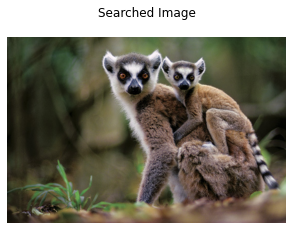

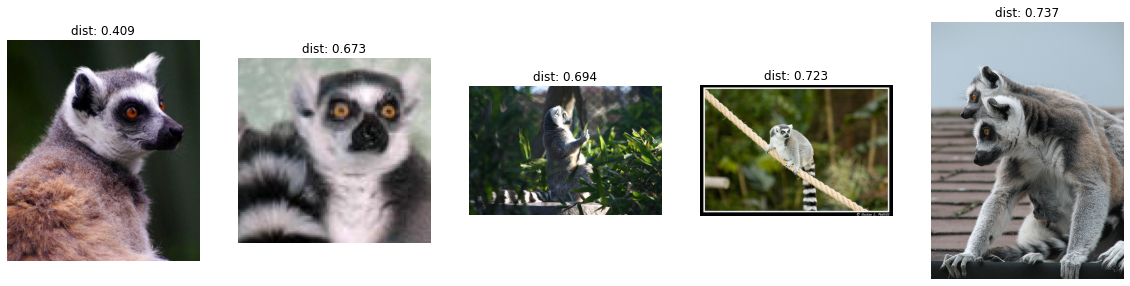

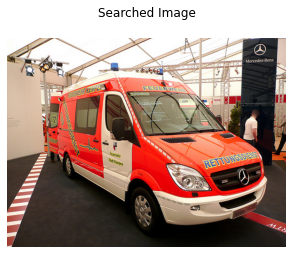

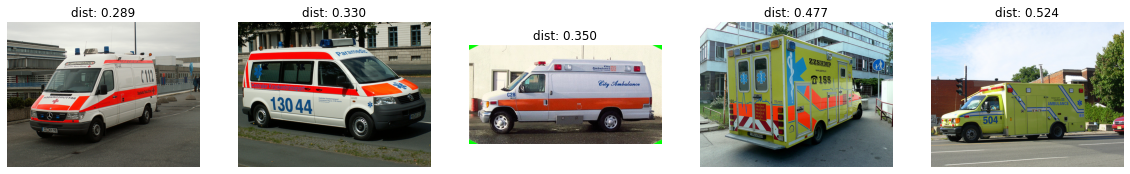

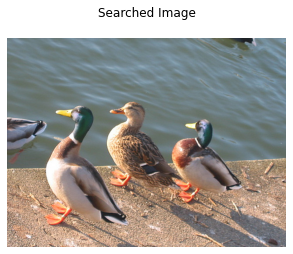

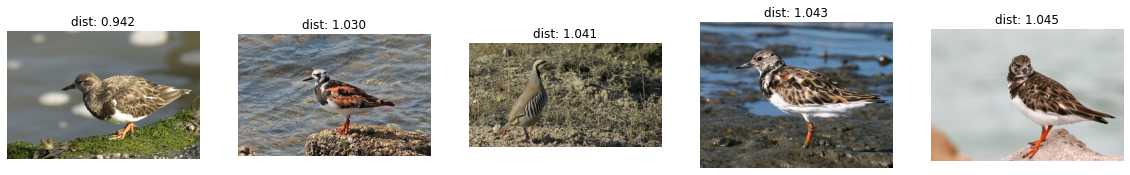

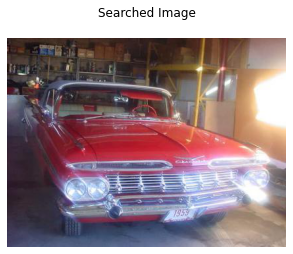

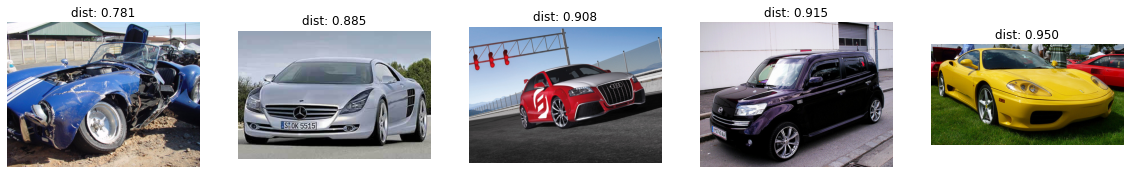

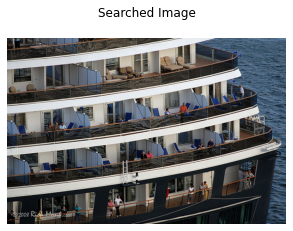

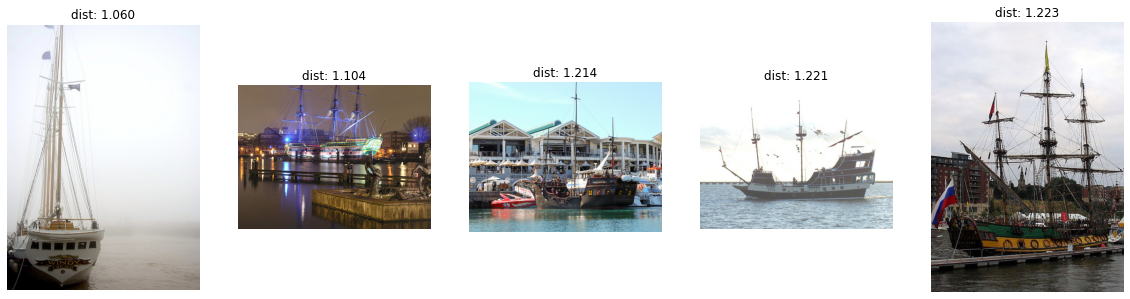

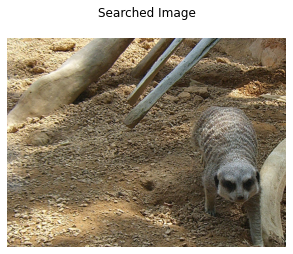

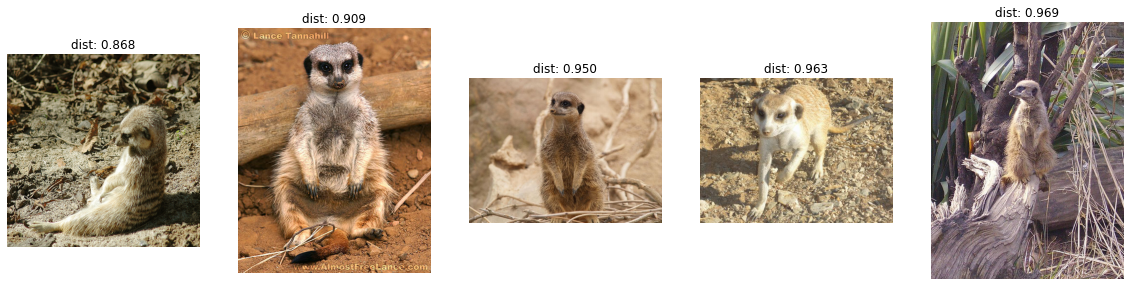

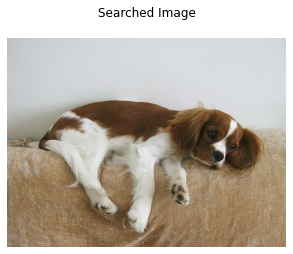

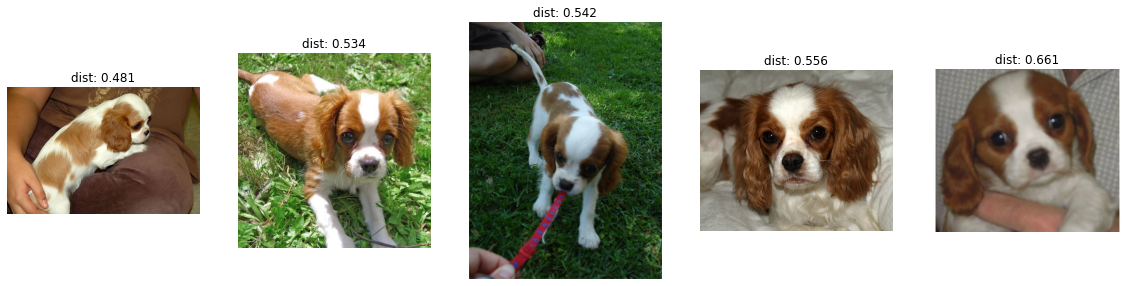

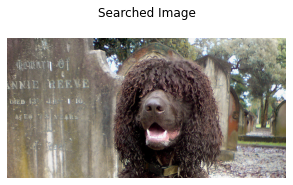

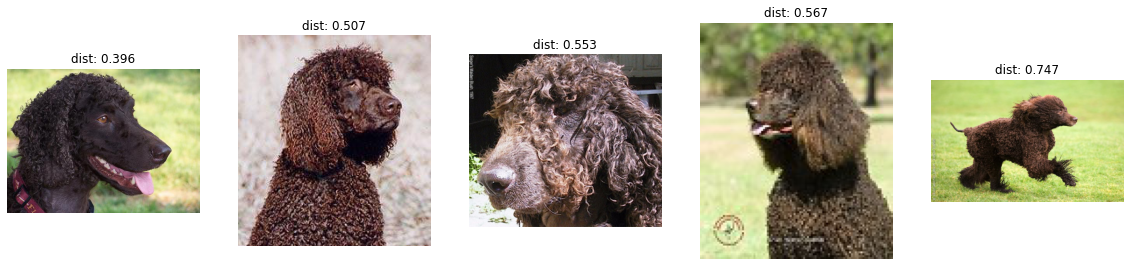

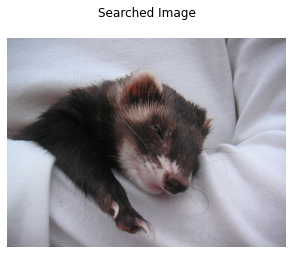

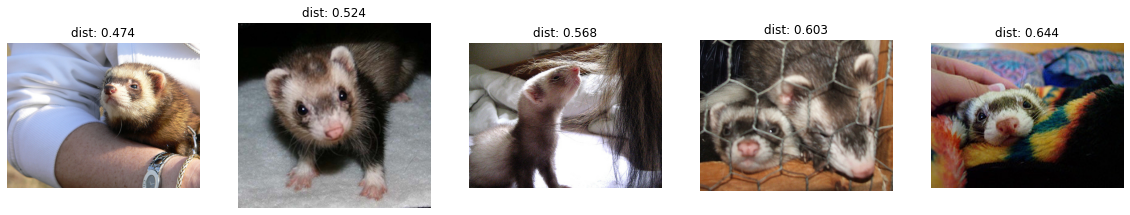

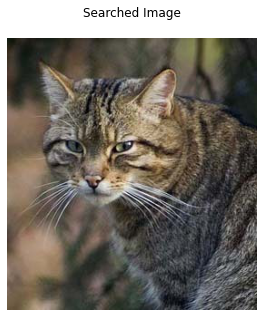

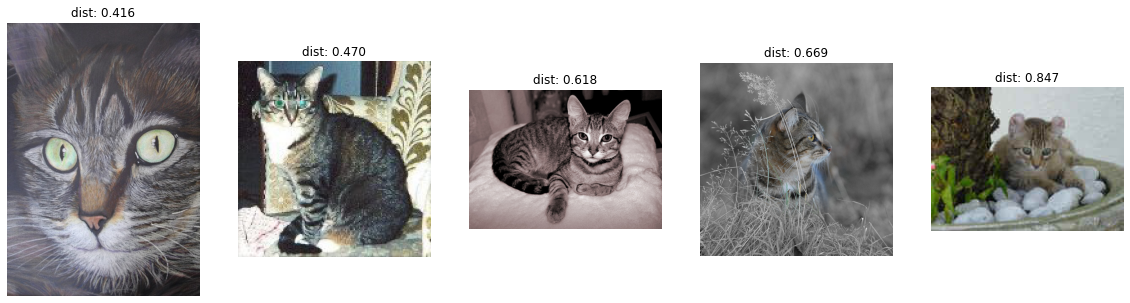

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

for i in range(len(query_results)):
    results = query_results[i]
    query_file = query_images[i]
    
    result_files = [img_dict[result.id] for result in results]
    distances = [result.distance for result in results]

    fig_query, ax_query = plt.subplots(1,1, figsize=(5,5))
    ax_query.imshow(Image.open(query_file))
    ax_query.set_title("Searched Image\n")
    ax_query.axis('off')

    fig, ax = plt.subplots(1,len(result_files),figsize=(20,20))
    for x in range(len(result_files)):
        ax[x].imshow(Image.open(result_files[x]))
        ax[x].set_title('dist: ' + str(distances[x])[0:5])
        ax[x].axis('off')